In [1]:
import spotipy
import spotipy.util as util
import pandas as pd 
import numpy as np
import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix

In [2]:
# Functions and Organization is important
%run PearPlaylistFunctions.ipynb

In [3]:
%run PearPlaylistClasses.ipynb

In [4]:
# TODO: Turn into Function
scope = 'user-library-read'
client_id ='a63ddab3e3d147898a0df1d5658f9ee9'
client_secret ='226f21e7e723484f909f768fdadada7c'
redirect_uri ='http://localhost/'

# Profile url: https://open.spotify.com/user/22r6slwbns4u7hkhn3hjhjhyi?si=MX4wzJ3PQeiH_7IKIHHrMA
# Find way so that users don't have to get their link
username = '22r6slwbns4u7hkhn3hjhjhyi'

In [ ]:
# Prompt User to Login

token = util.prompt_for_user_token(username, scope = scope, client_id = client_id, client_secret = client_secret, redirect_uri = redirect_uri)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=a63ddab3e3d147898a0df1d5658f9ee9&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%2F&scope=user-library-read in your browser




In [12]:
playlist_names = ['Rock', 'Dad Music']

#playlist_1 = Playlist_Base(playlist_name = 'Chill Alt Rock', username = username, token = token)
#playlist_2 = Playlist_Base(playlist_name = 'Chill Rap', username = username, token = token)

In [13]:
# Given names create Playlist_Base objects for each playlist
# This includes a dict returned from the API as well as features of the tracks of the playlist
# Also includes a set of recommendations and their features
playlist_bases = [None]*len(playlist_names)
feature_dfs = [None]*len(playlist_names)
for i, playlist_name in enumerate(playlist_names):
    cur_playlist_base = Playlist_Base(playlist_name = playlist_name, username = username, token = token)
    playlist_bases[i] = cur_playlist_base 
    feature_dfs[i] = cur_playlist_base.orig_playlist_tracks_df

In [14]:
# Combine all tracks and perform PCA (for 3D plotting purposes)
# For actual analysis we can just use all 7(?) columns of the df, but we can't visualize things in 7 dimensions...
comb_pca_dfs = pca_merge(feature_dfs)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0
1
Distribution of songs based on first 3 PCA variables


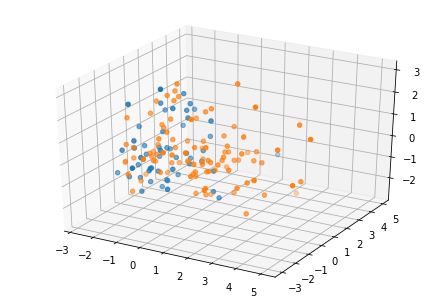

In [15]:
# NOW LET'S PLOTS SOME SHIT IN 3D

# TODO: Figure out better way to plot this...
playlists_pca = [None]*len(feature_dfs)
for i in range(0, len(feature_dfs)):
    playlists_pca[i] = comb_pca_dfs[comb_pca_dfs['playlist_iter'] == i]

fig = pyplot.figure()
ax = Axes3D(fig)
for i, playlist_pca in enumerate(playlists_pca):
    print(i)
    ax.scatter(playlist_pca['principal component 1'], playlist_pca['principal component 2'], playlist_pca['principal component 3'])
print("Distribution of songs based on first 3 PCA variables")
pyplot.show()

In [ ]:
### NOW WORK ON RECOMMENDATIONS
# First just build out hard-coded 2 playlist build, later turn into multi-playlist recs

In [49]:
playlist_bases

In [16]:
#Given set of Playlist_bases objects, get a distance matrix of all tracks to all other tracks (will be redundancies)
# Assumes the rec_tracks_df of all base playlists is the same
def get_track_distances(playlist_bases):

    # Need a df with all tracks as rows
    # All features as columns

    # Create empty data frame to union results onto
    all_rec_tracks_tmp = pd.DataFrame(columns = playlist_bases[0].rec_tracks_df.columns)
    all_orig_tracks_tmp = pd.DataFrame(columns = playlist_bases[0].orig_playlist_tracks_df.columns)
    
    for playlist_base in playlist_bases:
        rec_tracks_df = playlist_base.rec_tracks_df
        all_rec_tracks_tmp = all_rec_tracks_tmp.append(rec_tracks_df)
        orig_playlist_tracks_df = playlist_base.orig_playlist_tracks_df
        all_orig_tracks_tmp = all_orig_tracks_tmp.append(orig_playlist_tracks_df)
        
    # Mode & Key did bad stuff in early analysis
    all_rec_tracks = all_rec_tracks_tmp.reset_index().drop(['index','mode', 'key'], axis = 1)
    all_orig_tracks = all_orig_tracks_tmp.reset_index().drop(['index','mode', 'key'], axis = 1)
    
    # Now get all original tracks, compare distance 


    all_tracks = all_rec_tracks.append(all_orig_tracks).reset_index().drop(['index'], axis = 1)
    
    all_tracks_scaled = pd.DataFrame(StandardScaler().fit_transform(all_tracks.drop(['track_id'], axis = 1)))

    
    all_rec_tracks_scaled = all_tracks_scaled.iloc[0:len(all_rec_tracks)]
    all_rec_tracks_scaled['track_id'] = all_rec_tracks['track_id']
    all_orig_tracks_scaled = all_tracks_scaled.iloc[len(all_rec_tracks):all_tracks_scaled.shape[0]].reset_index().drop(['index'], axis = 1)
    all_orig_tracks_scaled['track_id'] = all_orig_tracks['track_id']
    
    all_tracks_scaled['track_id'] = all_tracks['track_id']
    ### Normalize that shit before doing the distance matrix, have to put in same df to normalize
    ### 
#    dist_matrix = pd.DataFrame(distance_matrix(all_rec_tracks.drop(['track_id'], axis = 1).values, all_orig_tracks.drop(['track_id'], axis = 1).values))
    
    return all_tracks, all_rec_tracks, all_orig_tracks, all_tracks_scaled, all_rec_tracks_scaled, all_orig_tracks_scaled


In [17]:
all_tracks, all_rec_tracks, all_orig_tracks, all_tracks_scaled, all_rec_tracks_scaled, all_orig_tracks_scaled = get_track_distances(playlist_bases)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
dist_matrix = pd.DataFrame(distance_matrix(all_rec_tracks_scaled.drop(['track_id'], axis = 1).values, all_orig_tracks_scaled.drop(['track_id'], axis = 1).values))

In [19]:
# Now have a distance matrix whose rows are all of our recommended tracks
# Columns are all original tracks, and values are the distance between the songs (after all were normalized together)
# Make the column names and row names the actual track_ids 
dist_matrix.columns = all_orig_tracks['track_id']
dist_matrix.insert(0, 'track_id', all_rec_tracks['track_id'])

In [21]:
# for each recommended track, calculate avg distance to each original playlist (avg over all songs in playlist)
# BE CAREFUL WITH INDICES

# Look at each recommended track
# Store each track in a df, with each column being the distance to one of the playlists
p0_track_ids = playlist_bases[0].orig_playlist_tracks_df['track_id']
p1_track_ids = playlist_bases[1].orig_playlist_tracks_df['track_id']




# Make 3 lists to insert into data frame - PFI: need a more robust solution for more playlists
track_ids = [None]*len(dist_matrix)
p0_dist = [None]*len(dist_matrix)
p1_dist = [None]*len(dist_matrix)
for index, rec_track in dist_matrix.iterrows():
    # The index of each 'rec_track' is every column in the df (aka all original tracks)
    # We want to subset this to the specific playlists so that we can determine distance to each playlist
    track_ids[index] = rec_track['track_id']
    
    # the track ids in p0_track_ids should match the columns (aka index) of rec_track
    # Only look at those, then get avg dist
    p0_track_distances = rec_track[rec_track.index.isin(p0_track_ids)]
    p0_dist[index] = p0_track_distances.mean()
    
    p1_track_distances = rec_track[rec_track.index.isin(p1_track_ids)]
    p1_dist[index] = p1_track_distances.mean()

cols = ['track_id', 'p0', 'p1']
rec_tracks_to_playlists = pd.DataFrame({'track_id' : track_ids, 'p0': p0_dist, 'p1' : p1_dist})


In [24]:
# Now we have a list of tracks and their distance to each playlist
# Pull n tracks that are "closest" to each playlist (could do lowest avg, could do 2 smallest, weight larger vals worse, etc...)
# PFI: Change up this algorithm
rec_tracks_to_playlists['avg_dist'] = rec_tracks_to_playlists.mean(axis = 1)

In [26]:
final_tracks = rec_tracks_to_playlists.sort_values(by = ['avg_dist']).iloc[0:20]

In [27]:
# Lastly, make a playlist from these tracks - adjust token to modify public playlists
scope = 'playlist-modify-public'
token2 = util.prompt_for_user_token(username, scope = scope, client_id = client_id, client_secret = client_secret, redirect_uri = redirect_uri)




            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=a63ddab3e3d147898a0df1d5658f9ee9&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%2F&scope=playlist-modify-public in your browser


Enter the URL you were redirected to: http://localhost/?code=AQD4WvMQ3TTWufxLPGBAJJ0QE6Ha6C4BJq_Kwp7dzbu2u8siuGLTYWPSz32K_ZwwMN5UYkZ_GJczXPGXP2F1_yz1dkUtwjfO7n3bD_9VkZA1VoOOrpjxWUEJ2dRdiTcLIi1F7bBqLZNLpi9sAVoPqtqDEuoRsW8H3iw3_sTYOpTs4bRSB_2lRh962JEWHgMs0uWV0sQK2GVeyjSpRlm_Y4k




In [31]:
sp = spotipy.Spotify(auth=token2)
sp.user_playlist_create(username, "SpotiPear_Playlist", public = True)

{'collaborative': False,
 'description': None,
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/2xbQ0MZjSRQqodhs0Sz3dH'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/2xbQ0MZjSRQqodhs0Sz3dH',
 'id': '2xbQ0MZjSRQqodhs0Sz3dH',
 'images': [],
 'name': 'SpotiPear_Playlist',
 'owner': {'display_name': 'Otis Skipper',
  'external_urls': {'spotify': 'https://open.spotify.com/user/22r6slwbns4u7hkhn3hjhjhyi'},
  'href': 'https://api.spotify.com/v1/users/22r6slwbns4u7hkhn3hjhjhyi',
  'id': '22r6slwbns4u7hkhn3hjhjhyi',
  'type': 'user',
  'uri': 'spotify:user:22r6slwbns4u7hkhn3hjhjhyi'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSwwNDZjNDllMDUxNDUxMTNkZjk3NGI4NDExYjhlM2NiYWZkZmM4MWZj',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/2xbQ0MZjSRQqodhs0Sz3dH/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:user:22r6slwbn

In [34]:
# Now let's add some tracks
track_ids_to_add = final_tracks['track_id']
# TODO: Dynamically pull playlistid
sp.user_playlist_add_tracks(username, '2xbQ0MZjSRQqodhs0Sz3dH', track_ids_to_add)

{'snapshot_id': 'Miw1NDY5MTdlYjU2YmI3ZWE3OGM4MjJkZjZhN2IwNmRjMzNjYWY3MGMw'}

In [ ]:
# LEGEND
#TODO: Go back and fix/add things
#PFI: Possible feature improvement
#PSI: Possible speed improvement for larger data sets
#PSS: Possible syntax improvement - it works but could be done more eloquently 